In [5]:
#Load final training df as generated from notebook 1.4
import pandas as pd

raw_df = pd.read_csv("full_dset.csv") #assume df within repository and not in local data repositories

#todo name cols accordingly
raw_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.028471,0.002779,3.146846,0.053351,0.043814,0.273602,0.050972,0.056350,-85.844057,0.421254,...,0.004551,0.003261,0.005506,0.000446,0.001040,0.003077,0.004108,0.002468,0.048763,healthy
1,0.133642,0.002768,2.869909,0.309003,0.245174,1.881792,0.012808,0.408492,-37.052363,1.523755,...,0.018839,0.016777,0.018911,0.003080,0.009004,0.016148,0.012809,0.005871,0.017485,healthy
2,0.218935,0.005202,2.897677,0.297827,0.222117,1.665932,0.014579,0.361100,-31.968553,1.688505,...,0.017594,0.015448,0.013448,0.004682,0.008954,0.012718,0.017895,0.008825,0.018730,healthy
3,0.160827,0.027925,3.024841,0.277583,0.234702,1.273127,0.021699,0.268800,-30.571378,1.726140,...,0.081715,0.011529,0.019183,0.006732,0.009730,0.014826,0.012165,0.006421,0.031882,healthy
4,0.217478,0.005380,3.094527,0.390247,0.249535,2.143341,0.037738,0.578800,-44.845560,0.054344,...,0.004751,0.004427,0.009032,0.003588,0.005457,0.006057,0.006948,0.005003,0.020612,healthy


In [6]:
import pandas as pd

# 1. Find the count of the least frequent class
target_col = raw_df.columns[-1]
class_counts = raw_df[target_col].value_counts()
min_size = class_counts.min()
least_frequent_class = class_counts.idxmin()

print(f"Least frequent class: {least_frequent_class} ({min_size} samples)")

# 2. Create a new dataframe by sampling each group to the min_size
new_df = raw_df.groupby(target_col, group_keys=False).apply(lambda x: x.sample(min_size, random_state=42))

# 3. Optional: Shuffle the new dataframe
df = new_df.sample(frac=1).reset_index(drop=True)

print("New class distribution:")
print(df[target_col].value_counts())

Least frequent class: COVID-19 (1313 samples)
New class distribution:
34
symptomatic    1313
healthy        1313
COVID-19       1313
Name: count, dtype: int64


C:\Users\kosta\AppData\Local\Temp\ipykernel_16192\1041719749.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = raw_df.groupby(target_col, group_keys=False).apply(lambda x: x.sample(min_size, random_state=42))


In [7]:
#sample testing split
#TODO k fold validations more dynamic train test splits opposed to 80/20
from sklearn.model_selection import train_test_split 
from sklearn import svm

X = df.iloc[: , :-1] #everything except last column
y = df.iloc[:, 34] #last column
print(" shape", X.shape)
print("y shape", y.shape)

#test anything else as far as splits goes here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y.head)

 shape (3939, 34)
y shape (3939,)
<bound method NDFrame.head of 0       symptomatic
1           healthy
2       symptomatic
3       symptomatic
4           healthy
           ...     
3934        healthy
3935       COVID-19
3936        healthy
3937        healthy
3938    symptomatic
Name: 34, Length: 3939, dtype: object>


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


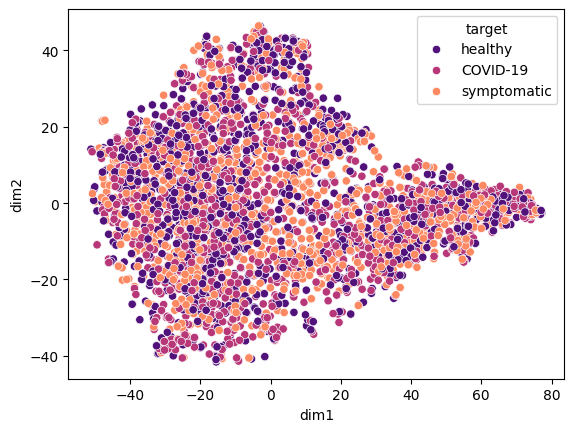

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt 


# 1. Initialize t-SNE (Perplexity is a key hyperparameter, usually 5-50)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

# 2. Create DataFrame
tsne_df = pd.DataFrame(data=X_tsne, columns=['dim1', 'dim2'])
tsne_df['target'] = y_train.values

# 3. Plot
sns.scatterplot(data=tsne_df, x='dim1', y='dim2', hue='target', palette='magma')
plt.show()

In [11]:
from sklearn.decomposition import PCA

#apply pca to reduce feature space 
pca = PCA(n_components=0.90) #0.95 variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of components chosen: {pca.n_components_}")

Number of components chosen: 19


In [12]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


# 3. Define the Complex Model Search
# RBF kernel handles non-linear patterns by mapping to infinite dimensions
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],          # Penalty for misclassification
    'gamma': [1, 0.1, 0.01, 0.001],        # Kernel coefficient (influence radius)
    'kernel': ['rbf']                      # The 'complex' kernel
}

# 4. Use GridSearchCV to find the best version of the model
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_pca, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.0

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [1, 0.1, ...], 'kernel': ['rbf']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [15]:
# 5. Final Model
best_model = grid.best_estimator_
y_predict = best_model.predict(X_test_pca)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_predict))


Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.41      0.35      0.38       273
     healthy       0.39      0.32      0.35       275
 symptomatic       0.33      0.47      0.39       240

    accuracy                           0.37       788
   macro avg       0.38      0.38      0.37       788
weighted avg       0.38      0.37      0.37       788


Confusion Matrix:
[[ 95  67 111]
 [ 74  88 113]
 [ 60  68 112]]
